In [2]:
import sys
sys.path.append("/projects/pw8/wl45/open3spn2")
sys.path.append("/projects/pw8/wl45/openawsem")
sys.path.append("/Users/weilu/open3spn2")
sys.path.append("/Users/weilu/openmmawsem")
sys.path.append("C:/Users/luwei/Documents/GitHub/open3spn2")
sys.path.append("C:/Users/luwei/Documents/GitHub/openawsem")


import open3SPN2
import ffAWSEM
import time
import simtk.openmm
import simtk.openmm.app
import seaborn as sns


In [3]:
import scipy.spatial.distance as sdist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline



In [5]:
pd.set_option('display.max_columns', 1000)

In [6]:
plt.rcParams['figure.figsize'] = np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

In [7]:
def interaction_table(original_dna, index_convertion_dic, r_cutoff):
    #Calculate native distances
    CA_atoms=original_dna[original_dna.name=='CA']
    P_atoms=original_dna[original_dna.name=='P']
    d=sdist.cdist(CA_atoms[['x','y','z']],P_atoms[['x','y','z']])/10 #Distance in nanometers
    d_sq=pd.DataFrame(d,index=CA_atoms.index,columns=P_atoms.index)
    d=d_sq.copy()
    d['Protein']=d.index
    d=d.melt(id_vars=['Protein'])
    d=d.rename(columns={'variable': 'DNA', 'value': 'distance'})
    # r_cutoff = 1.8
    selection=d[d['distance']<r_cutoff].copy()
    selection["new_DNA"] = selection["DNA"].apply(lambda x:index_convertion_dic[x])
    selection["new_Protein"] = selection["Protein"].apply(lambda x:index_convertion_dic[x])
    return selection

def count_contact_2(interaction_table, frame, r_cutoff=1.8):
    p_pos = frame[interaction_table.new_Protein.values]
    d_pos = frame[interaction_table.new_DNA.values]
    all_r = np.sum((p_pos - d_pos)**2, axis=1)**0.5
    return np.sum(all_r < r_cutoff)

In [9]:
# read the DNA seqeunce from the crystal structure.
pdb_file = "/Users/weilu/Research/server/jun_week3_2020/protein_DNA/DNAProtein_Platform_OpenCL_date_20200226_pdb_1mnn_repetition_0_clean.pdb"
original_dna=open3SPN2.DNA.fromCoarsePDB(pdb_file).atoms

pdb_file = "/Users/weilu/Research/server/jun_week3_2020/man_made_DNA/1mnn_with_long_DNA.pdb"
# seq_file = "/Users/weilu/Research/server/jun_week3_2020/man_made_DNA/1mnn_with_long_DNA.seq"
new_dna=open3SPN2.DNA.fromCoarsePDB(pdb_file).atoms.reset_index()

In [ ]:
# for 1mnn
interacting_atom = ["CA", "P"]
a = original_dna.query("name in @interacting_atom").reset_index(drop=True)
n_atom = len(a)
b = new_dna.query("name in @interacting_atom").reset_index(drop=True)

index_convertion_dic = {}
for i in range(n_atom):
    res = a.iloc[i]
    chainID = res["chainID"]
    name = res["name"]
    if chainID == "A":
        resSeq = res["resSeq"] + 100
    if chainID == "B":
        resSeq = res["resSeq"] + 313
    else:
        resSeq = res["resSeq"]
    target_atom = b.query(f"resSeq=={resSeq} and name=='{name}'")
    try:
        target_index = int(target_atom["index"])
        from_index = int(res["serial"])
        # print(target_index, from_index)
        index_convertion_dic[from_index] = target_index
    except:
        print(resSeq, name)

In [180]:
import mdtraj
pdb_file = "/Users/weilu/Research/server/jun_week3_2020/man_made_DNA/1mnn_with_long_DNA.pdb"
# dcd_file = "/Users/weilu/Research/server/jun_week3_2020/man_made_DNA/large_DNA_long_jun22_1mnn_with_long_DNA_0_output.dcd"
dcd_file = "/Users/weilu/Research/server/jun_week3_2020/man_made_DNA/large_DNA_long_jun23_1mnn_with_long_DNA_0_output.dcd"


pdb_top=mdtraj.load_pdb(pdb_file)
dcd_traj=mdtraj.load_dcd(dcd_file,top=pdb_top)
frame=pdb_top.xyz[0]

In [181]:
#Calculate native distances
CA_atoms=original_dna[original_dna.name=='CA']
P_atoms=original_dna[original_dna.name=='P']
d=sdist.cdist(CA_atoms[['x','y','z']],P_atoms[['x','y','z']])/10 #Distance in nanometers
d_sq=pd.DataFrame(d,index=CA_atoms.index,columns=P_atoms.index)
d=d_sq.copy()
d['Protein']=d.index
d=d.melt(id_vars=['Protein'])
d=d.rename(columns={'variable': 'DNA', 'value': 'distance'})



In [182]:
r_cutoff = 1.8
# r_cutoff = 0.95
# r_cutoff = 0.65
selection=d[d['distance']<r_cutoff].copy()
selection["new_DNA"] = selection["DNA"].apply(lambda x:index_convertion_dic[x])
selection["new_Protein"] = selection["Protein"].apply(lambda x:index_convertion_dic[x])

d_min_native = selection.groupby("Protein")["distance"].min().values


# get the index of all P atoms in DNA.
P_index_new = new_dna.query("name == 'P'").reset_index(drop=True)["index"].values
# all protein index with native contact. in the long DNA complex.
# CA_index_new = selection["new_Protein"].unique()
CA_index_new = selection["new_Protein"].unique()
CA_index_new.sort()



In [196]:
CA_index_new.shape

(135,)

In [202]:

count_list = []
fraction_list = []
for i,frame in enumerate(dcd_traj.xyz):
    d_pos = frame[P_index_new]
    p_pos = frame[CA_index_new]
    d2 = sdist.cdist(d_pos, p_pos)
    n_contact = np.sum(d2.min(axis=0) < r_cutoff)
    count_list.append(n_contact)
    fraction_list.append(n_contact/len(CA_index_new))

# k = 1
test = f"/Users/weilu/Research/server/jun_week3_2020/man_made_DNA/large_DNA_long_jun23_1mnn_with_long_DNA_0_energies.csv"
test_energy = pd.read_csv(test)
test_energy

test_energy["num_of_contact"] = count_list
test_energy["fraction"] = fraction_list
test_energy["interface_energy"]=test_energy['ExclusionProteinDNA kJ/mol']+test_energy['ElectrostaticsProteinDNA kJ/mol']



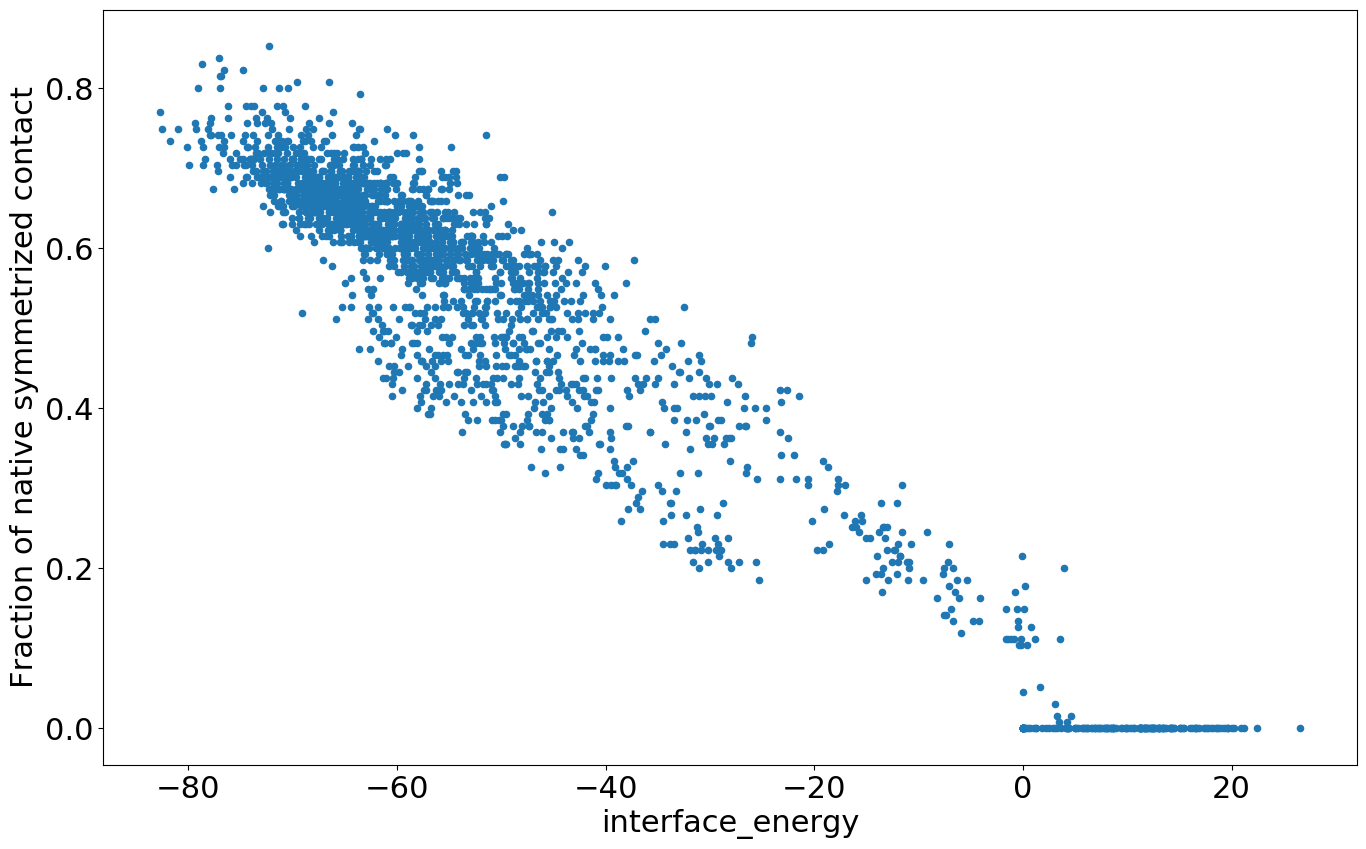

In [204]:
test_energy.plot.scatter("interface_energy", "fraction")
plt.ylabel("Fraction of native symmetrized contact")
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/protein_DNA.png")

In [185]:
run_1 = test_energy

In [190]:
data = pd.concat([run_0.assign(Run=0), run_1.assign(Run=1)]).reset_index(drop=True)

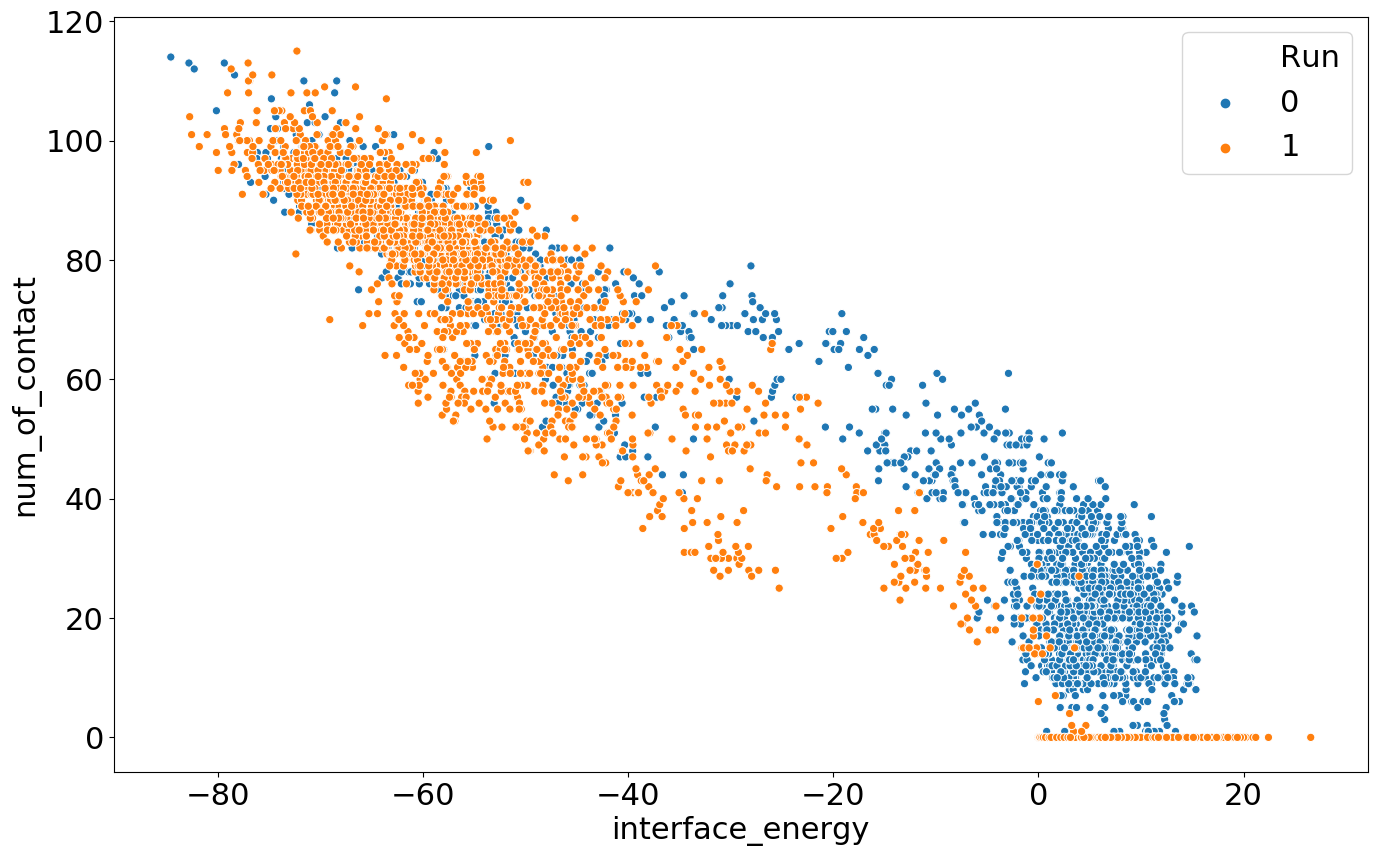

In [193]:
sns.scatterplot("interface_energy", "num_of_contact", hue="Run", data=data)

In [179]:
run_0 = test_energy

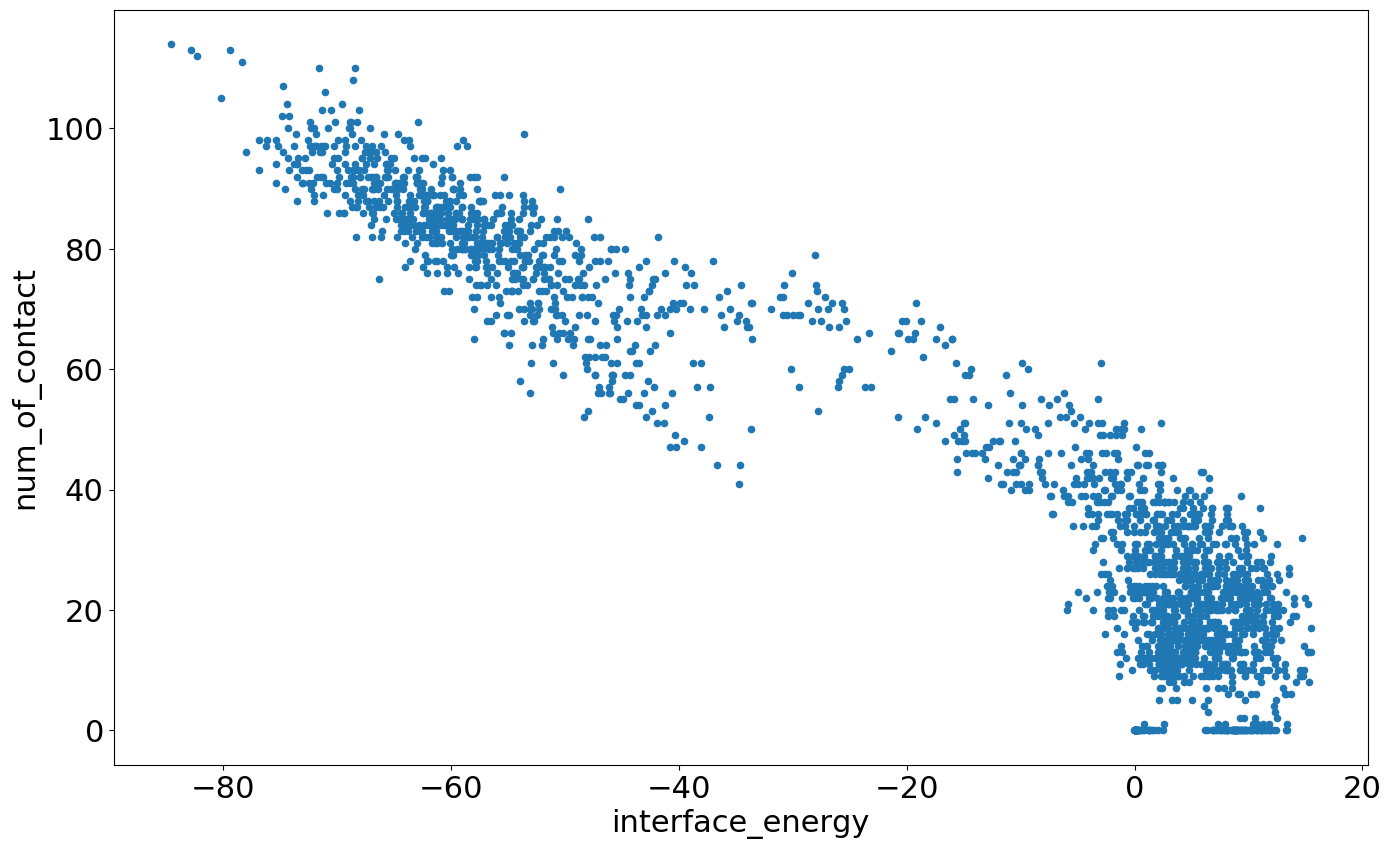

In [178]:
# r_cutoff = 1.8
# # r_cutoff = 0.95
# selection=d[d['distance']<r_cutoff].copy()
# selection["new_DNA"] = selection["DNA"].apply(lambda x:index_convertion_dic[x])
# selection["new_Protein"] = selection["Protein"].apply(lambda x:index_convertion_dic[x])

# d_min_native = selection.groupby("Protein")["distance"].min().values


# # get the index of all P atoms in DNA.
# P_index_new = new_dna.query("name == 'P'").reset_index(drop=True)["index"].values
# # all protein index with native contact. in the long DNA complex.
# # CA_index_new = selection["new_Protein"].unique()
# CA_index_new = selection["new_Protein"].unique()
# CA_index_new.sort()

# compute the distance between all.
# d_pos = frame[P_index_new]
# p_pos = frame[CA_index_new]
# d2 = sdist.cdist(d_pos, p_pos) / 10.0
# n_contact = np.sum(d2.min(axis=0) < r_cutoff)

# frame = dcd_traj.xyz[0]
# d_pos = frame[P_index_new]
# p_pos = frame[CA_index_new]
# d2 = sdist.cdist(p_pos, d_pos)
# q = np.exp(-(d2.min(axis=1) - d_min_native)**2/(2*.5**2))
# q_sum = np.sum(q)

# # get the index of all P atoms in DNA.
# P_index_new = new_dna.query("name == 'P'").reset_index(drop=True)["index"].values
# # all protein index with native contact. in the long DNA complex.
# CA_index_new = new_dna.query("name == 'CA'").reset_index(drop=True)["index"].values

In [135]:
# read the DNA seqeunce from the crystal structure.
pdb_file = "/Users/weilu/Research/server/jun_week3_2020/automatic_man_made_DNA/setups/with_formated_DNA_6cta_clean.pdb"
original_dna=open3SPN2.DNA.fromCoarsePDB(pdb_file).atoms

pdb_file = "/Users/weilu/Research/server/jun_week3_2020/automatic_man_made_DNA/6cta_with_long_DNA.pdb"
# seq_file = "/Users/weilu/Research/server/jun_week3_2020/man_made_DNA/1mnn_with_long_DNA.seq"
new_dna=open3SPN2.DNA.fromCoarsePDB(pdb_file).atoms.reset_index()

In [147]:
interacting_atom = ["CA", "P"]
a = original_dna.query("name in @interacting_atom").reset_index(drop=True)
n_atom = len(a)
b = new_dna.query("name in @interacting_atom").reset_index(drop=True)

index_convertion_dic = {}
for i in range(n_atom):
    res = a.iloc[i]
    chainID = res["chainID"]
    name = res["name"]
    if chainID == "B":
        resSeq = res["resSeq"] + 100
    if chainID == "C":
        resSeq = res["resSeq"] + 317
    if chainID == "A":
        resSeq = res["resSeq"] - 160
    target_atom = b.query(f"resSeq=={resSeq} and name=='{name}'")
    try:
        target_index = int(target_atom["index"])
        from_index = int(res["serial"])
        # print(target_index, from_index)
        index_convertion_dic[from_index] = target_index
    except:
        print(resSeq, name)

In [149]:

#Calculate native distances
CA_atoms=original_dna[original_dna.name=='CA']
P_atoms=original_dna[original_dna.name=='P']
d=sdist.cdist(CA_atoms[['x','y','z']],P_atoms[['x','y','z']])/10 #Distance in nanometers
d_sq=pd.DataFrame(d,index=CA_atoms.index,columns=P_atoms.index)
d=d_sq.copy()
d['Protein']=d.index
d=d.melt(id_vars=['Protein'])
d=d.rename(columns={'variable': 'DNA', 'value': 'distance'})

r_cutoff = 1.8
selection=d[d['distance']<r_cutoff].copy()
selection["new_DNA"] = selection["DNA"].apply(lambda x:index_convertion_dic[x])
selection["new_Protein"] = selection["Protein"].apply(lambda x:index_convertion_dic[x])

In [ ]:
import mdtraj
pdb_file = "/Users/weilu/Research/server/jun_week3_2020/automatic_man_made_DNA/6cta_with_long_DNA.pdb"
dcd_file = "/Users/weilu/Research/server/jun_week3_2020/automatic_man_made_DNA/jun23_local_6cta_with_long_DNA_0_output.dcd"
pdb_top=mdtraj.load_pdb(pdb_file)
dcd_traj=mdtraj.load_dcd(dcd_file,top=pdb_top)
frame=pdb_top.xyz[0]



In [154]:
dcd_traj.xyz

(2499, 3438, 3)

In [ ]:
test_energy

In [153]:
len(test_energy)

2500

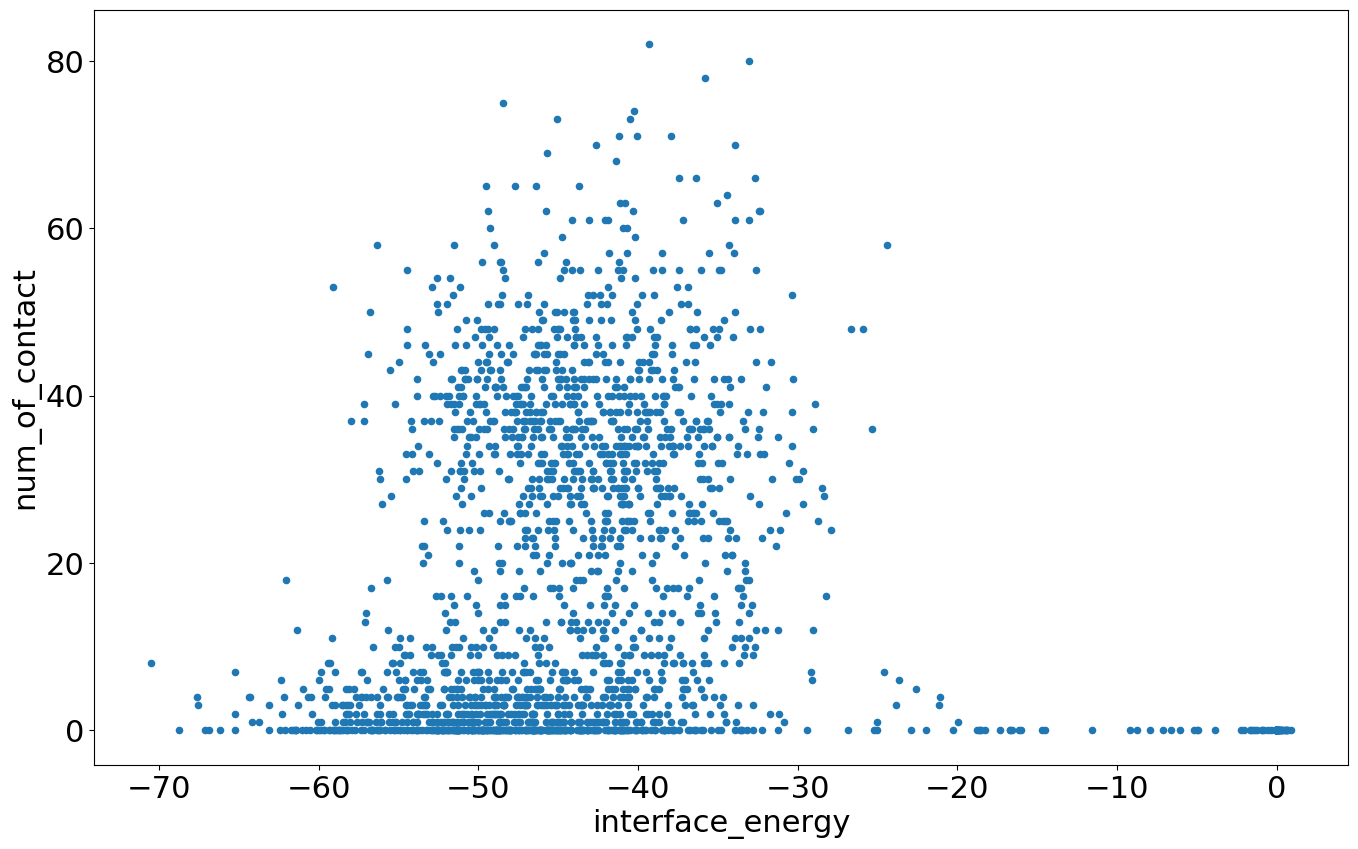

In [156]:

interaction_table = selection
count_list = [0]
for i,frame in enumerate(dcd_traj.xyz):
    count = count_contact_2(interaction_table, frame)
    # print(i, count)
    count_list.append(count)


# k = 1
test = f"/Users/weilu/Research/server/jun_week3_2020/automatic_man_made_DNA/jun23_local_6cta_with_long_DNA_0_energies.csv"
test_energy = pd.read_csv(test)
test_energy

test_energy["num_of_contact"] = count_list
test_energy["interface_energy"]=test_energy['ExclusionProteinDNA kJ/mol']+test_energy['ElectrostaticsProteinDNA kJ/mol']


test_energy.plot.scatter("interface_energy", "num_of_contact")

In [6]:
# read the DNA seqeunce from the crystal structure.
pdb_file = "/Users/weilu/Research/server/jun_week3_2020/protein_DNA/DNAProtein_Platform_OpenCL_date_20200226_pdb_1mnn_repetition_0_clean.pdb"
original_dna=open3SPN2.DNA.fromCoarsePDB(pdb_file).atoms

In [7]:
original_dna

,recname,serial,name,altLoc,resname,chainID,resSeq,iCode,x,y,z,occupancy,tempFactor,element,charge,type
0,ATOM,0,T,,DT,A,1,,34.611,3.249,59.381,0.0,0.0,S,,T
1,ATOM,1,S,,DT,A,1,,31.993,-0.127,59.441,0.0,0.0,H,,S
2,ATOM,2,G,,DG,A,2,,32.491,6.125,57.154,0.0,0.0,C,,G
3,ATOM,3,P,,DG,A,2,,28.371,0.201,58.401,0.0,0.0,P,,P
4,ATOM,4,S,,DG,A,2,,28.648,4.005,59.481,0.0,0.0,H,,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,ATOM,1859,N,,NGP,C,303,,22.673,0.312,41.331,0.0,0.0,N,,N
1860,ATOM,1860,H,,NGP,C,303,,22.132,1.109,41.403,0.0,0.0,H,,H
1861,ATOM,1861,CA,,NGP,C,303,,22.202,-0.633,40.300,0.0,0.0,C,,CA
1862,ATOM,1862,O,,NGP,C,303,,23.097,0.931,38.712,0.0,0.0,O,,O


In [8]:
pdb_file = "/Users/weilu/Research/server/jun_week3_2020/man_made_DNA/1mnn_with_long_DNA.pdb"
seq_file = "/Users/weilu/Research/server/jun_week3_2020/man_made_DNA/1mnn_with_long_DNA.seq"
new_dna=open3SPN2.DNA.fromCoarsePDB(pdb_file).atoms.reset_index()

In [9]:
new_dna

,index,recname,serial,name,altLoc,resname,chainID,resSeq,iCode,x,y,z,occupancy,tempFactor,element,charge,type
0,0,ATOM,1,A,,DA,A,1,,-0.440,2.425,0.012,0.0,0.0,N,,A
1,1,ATOM,2,S,,DA,A,1,,-2.790,6.611,-0.769,0.0,0.0,H,,S
2,2,ATOM,3,A,,DA,A,2,,-1.740,1.565,3.231,0.0,0.0,N,,A
3,3,ATOM,4,P,,DA,A,2,,-5.581,7.213,1.561,0.0,0.0,P,,P
4,4,ATOM,5,S,,DA,A,2,,-6.079,3.596,2.392,0.0,0.0,H,,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3059,3059,ATOM,1778,N,,NGP,C,303,,122.673,0.312,41.331,1.0,0.0,N,,N
3060,3060,ATOM,1779,H,,NGP,C,303,,122.132,1.109,41.403,1.0,0.0,H,,H
3061,3061,ATOM,1780,CA,,NGP,C,303,,122.202,-0.633,40.300,1.0,0.0,C,,CA
3062,3062,ATOM,1781,O,,NGP,C,303,,123.097,0.931,38.712,1.0,0.0,O,,O


In [23]:
len('TGCGACACAAAAAC')

14

In [25]:
new_dna.query("name == 'P' and resSeq > 100 and resSeq < 115")

,index,recname,serial,name,altLoc,resname,chainID,resSeq,iCode,x,y,z,occupancy,tempFactor,element,charge,type
300,300,ATOM,301,P,,DT,A,101,,-8.969,11.513,325.099,0.0,0.0,P,,P
303,303,ATOM,304,P,,DG,A,102,,-12.773,15.547,328.443,0.0,0.0,P,,P
306,306,ATOM,307,P,,DC,A,103,,-18.173,16.497,331.890,0.0,0.0,P,,P
309,309,ATOM,310,P,,DG,A,104,,-23.480,14.668,335.373,0.0,0.0,P,,P
312,312,ATOM,313,P,,DA,A,105,,-26.512,9.760,338.665,0.0,0.0,P,,P
315,315,ATOM,316,P,,DC,A,106,,-25.905,4.787,342.006,0.0,0.0,P,,P
318,318,ATOM,319,P,,DA,A,107,,-22.654,0.125,345.549,0.0,0.0,P,,P
321,321,ATOM,322,P,,DC,A,108,,-17.899,-1.163,349.029,0.0,0.0,P,,P
324,324,ATOM,325,P,,DA,A,109,,-12.359,0.122,352.568,0.0,0.0,P,,P
327,327,ATOM,328,P,,DA,A,110,,-8.724,4.508,355.692,0.0,0.0,P,,P


In [30]:
a

,recname,serial,name,altLoc,resname,chainID,resSeq,iCode,x,y,z,occupancy,tempFactor,element,charge,type
0,ATOM,3,P,,DG,A,2,,28.371,0.201,58.401,0.0,0.0,P,,P
1,ATOM,6,P,,DC,A,3,,25.929,6.574,60.114,0.0,0.0,P,,P
2,ATOM,9,P,,DG,A,4,,27.055,13.017,61.289,0.0,0.0,P,,P
3,ATOM,12,P,,DA,A,5,,29.804,19.091,59.915,0.0,0.0,P,,P
4,ATOM,15,P,,DC,A,6,,31.584,22.416,54.566,0.0,0.0,P,,P
5,ATOM,18,P,,DA,A,7,,31.635,22.825,47.708,0.0,0.0,P,,P
6,ATOM,21,P,,DC,A,8,,30.132,20.887,41.919,0.0,0.0,P,,P
7,ATOM,24,P,,DA,A,9,,25.564,18.527,37.598,0.0,0.0,P,,P
8,ATOM,27,P,,DA,A,10,,19.379,17.309,36.145,0.0,0.0,P,,P
9,ATOM,30,P,,DA,A,11,,12.925,18.148,36.371,0.0,0.0,P,,P


In [31]:
# k = 1
# bond_length_cutoff=1.8

# bonds_list = []
# DNA_resNames = ["DA", "DC", "DT", "DG"]
# interacting_atom = ["P"]
# a = original_dna.query("resname in @DNA_resNames").query("name in @interacting_atom").reset_index(drop=True)
# n_atom = len(a)
# b = new_dna.query("resname in @DNA_resNames").query("name in @interacting_atom").reset_index(drop=True)

In [56]:
interacting_atom = ["CA", "P"]
a = original_dna.query("name in @interacting_atom").reset_index(drop=True)
n_atom = len(a)
b = new_dna.query("name in @interacting_atom").reset_index(drop=True)

index_convertion_dic = {}
for i in range(n_atom):
    res = a.iloc[i]
    chainID = res["chainID"]
    name = res["name"]
    if chainID == "A":
        resSeq = res["resSeq"] + 100
    if chainID == "B":
        resSeq = res["resSeq"] + 313
    if chainID == "C":
        resSeq = res["resSeq"]
    target_atom = b.query(f"resSeq=={resSeq} and name=='{name}'")
    target_index = int(target_atom["index"])
    from_index = int(res["serial"])
    # print(target_index, from_index)
    index_convertion_dic[from_index] = target_index

In [ ]:
interaction_table(original_dna, index_convertion_dic, r_cutoff)

In [126]:
interaction_table(original_dna, index_convertion_dic, r_cutoff)

,Protein,DNA,distance,new_DNA,new_Protein
18,189,3,1.734734,303,1389
75,523,3,1.793277,303,1723
76,528,3,1.540306,303,1728
77,534,3,1.368388,303,1734
78,540,3,1.494515,303,1740
...,...,...,...,...,...
7268,1843,74,1.779954,971,3043
7269,1849,74,1.428330,971,3049
7270,1855,74,1.467192,971,3055
7271,1861,74,1.776103,971,3061


,Protein,DNA,distance,new_DNA,new_Protein
229,1436,3,0.928501,303,2636
231,1448,3,0.966305,303,2648
292,1803,3,0.910363,303,3003
293,1808,3,0.872757,303,3008
294,1814,3,0.733991,303,3014
...,...,...,...,...,...
6662,1843,68,0.698697,965,3043
6663,1849,68,0.497517,965,3049
6664,1855,68,0.779409,965,3055
6966,1849,71,0.825378,968,3049


In [129]:
r_cutoff = 1.0
interaction_table = interaction_table(original_dna, index_convertion_dic, r_cutoff)
count_list = []
for i,frame in enumerate(dcd_traj.xyz):
    count = count_contact_2(interaction_table, frame, r_cutoff=r_cutoff)
    # print(i, count)
    count_list.append(count)
test_energy["num_of_contact_cutoff_1"] = count_list

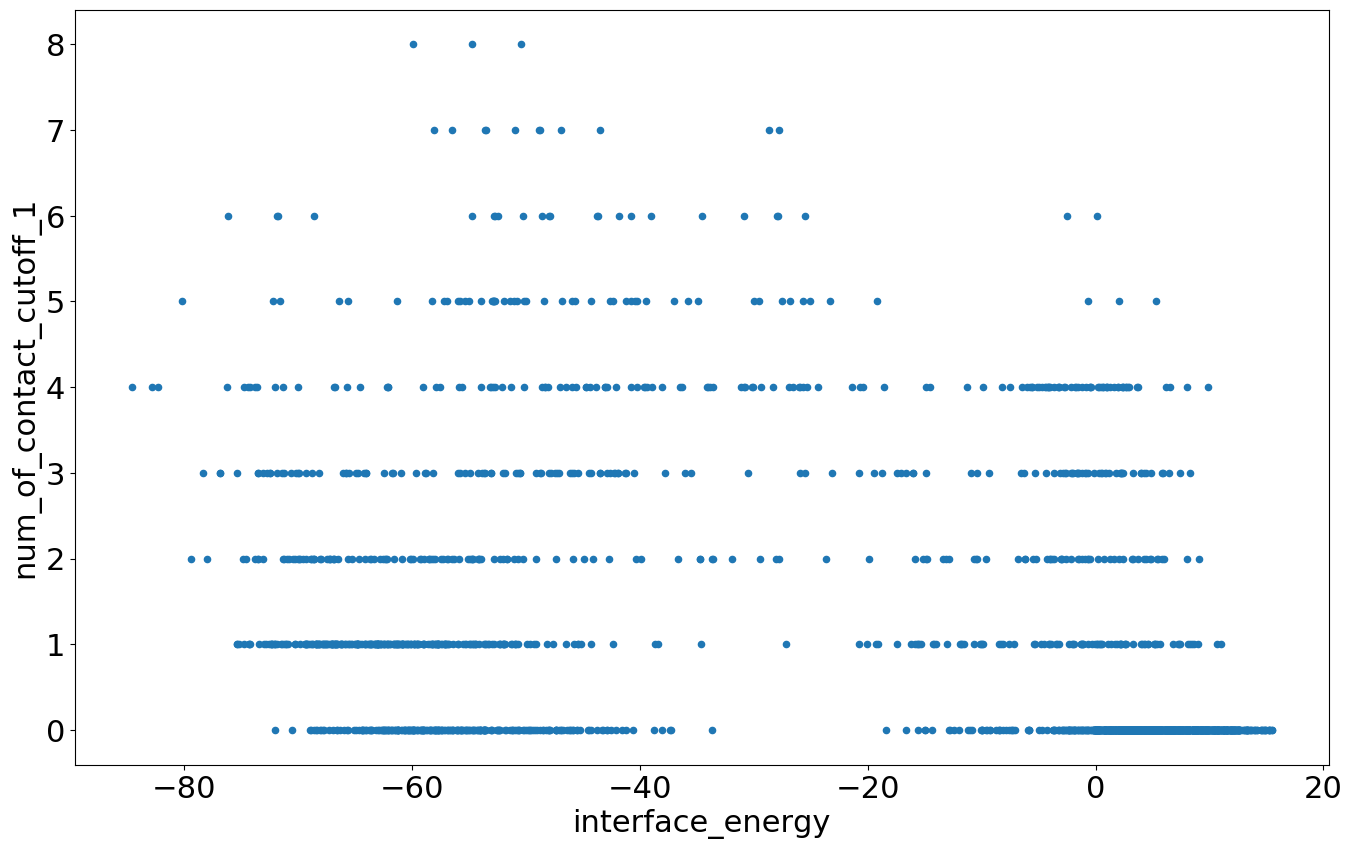

In [130]:
test_energy.plot.scatter("interface_energy", "num_of_contact_cutoff_1")

In [134]:
test_energy.sort_values("num_of_contact")

,Unnamed: 0,TotalEnergy kJ/mol,dna_constraint kJ/mol,constraint kJ/mol,Bond kJ/mol,Angle kJ/mol,Stacking kJ/mol,Dihedral kJ/mol,BasePair kJ/mol,CrossStacking kJ/mol,Exclusion kJ/mol,Electrostatics kJ/mol,Connectivity kJ/mol,Chain kJ/mol,Chi kJ/mol,Excl kJ/mol,rama kJ/mol,rama_pro kJ/mol,contact kJ/mol,beta1 kJ/mol,beta2 kJ/mol,beta3 kJ/mol,pap1 kJ/mol,pap2 kJ/mol,fm kJ/mol,ExclusionProteinDNA kJ/mol,ElectrostaticsProteinDNA kJ/mol,Q_protein kJ/mol,Q_value_sigma5,Q_value_sigma3,Q_value_sigma1,Q_value_sym_sigma5,Q_value_sym_sigma3,Q_value_sym_sigma1,interface_energy,num_of_contact,num_of_contact_cutoff_1
0,0,-24457.537109,183.714249,2800.833984,659.545166,2800.833984,-5011.828613,-5510.080078,-2709.732422,-775.163391,0.700881,348.124573,2882.879883,2882.879883,2882.879883,2882.879883,-2686.058350,-2686.058350,-1314.762695,-704.685181,-704.685181,-704.685181,-184.406342,-184.406342,-12437.461914,0.000000,0.000000,0.843371,0.0,0.0,0.0,NaN,NaN,NaN,0.000000,0,0
424,424,-22622.693359,183.797348,4279.550781,697.771362,4279.550781,-4995.691406,-5468.636719,-2680.011230,-778.434570,0.475415,355.611511,2960.738770,2960.738770,2960.738770,2960.738770,-2710.322021,-2710.322021,-1372.692139,-610.591309,-610.591309,-610.591309,-167.721558,-167.721558,-12319.166992,-2.056760,3.966715,0.722510,0.0,0.0,0.0,NaN,NaN,NaN,1.909955,0,0
425,425,-22879.998047,175.827545,4087.518799,748.604065,4087.518799,-4976.041992,-5483.489258,-2689.521729,-761.500305,0.407753,353.877075,2980.070312,2980.070312,2980.070312,2980.070557,-2726.234375,-2726.234375,-1332.404175,-676.049194,-676.049194,-676.049194,-185.412689,-185.412689,-12404.447266,-1.923974,9.980200,0.740847,0.0,0.0,0.0,NaN,NaN,NaN,8.056226,0,0
426,426,-22688.087891,187.119324,4215.716797,704.494629,4215.716797,-4852.030273,-5482.895020,-2666.639160,-747.118530,0.336872,350.405579,2842.520996,2842.520996,2842.520996,2842.520996,-2684.580078,-2684.580078,-1340.677002,-677.371277,-677.371277,-677.371277,-181.089233,-181.089233,-12359.454102,-2.861691,5.328072,0.707914,0.0,0.0,0.0,NaN,NaN,NaN,2.466381,0,0
427,427,-22911.119141,178.959152,4114.760742,711.863770,4114.760742,-5010.979980,-5473.241699,-2687.214111,-742.350220,0.142810,350.561646,2872.285156,2872.285156,2872.285156,2872.285156,-2670.716797,-2670.716797,-1374.930786,-645.819031,-645.819031,-645.819031,-168.005920,-168.005920,-12373.639648,-1.644032,8.146694,0.703507,0.0,0.0,0.0,NaN,NaN,NaN,6.502662,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981,1981,-21569.289062,169.961502,5455.641602,688.925049,5455.641602,-5037.020996,-5486.022461,-2619.817139,-748.449524,0.196095,353.839539,3038.282959,3038.283203,3038.282959,3038.283203,-2679.888184,-2679.888184,-1342.412842,-661.149170,-661.149170,-661.149170,-179.060318,-179.060318,-12443.650391,-15.920072,-63.437153,0.693371,0.0,0.0,0.0,NaN,NaN,NaN,-79.357225,115,2
1998,1998,-21840.566406,186.495255,5455.048340,666.676697,5455.048340,-4977.398926,-5507.363281,-2692.340576,-751.145386,0.385615,349.804260,2867.435547,2867.435547,2867.435791,2867.435791,-2757.576904,-2757.576904,-1366.594482,-671.566650,-671.566650,-671.566650,-168.463470,-168.463470,-12396.373047,-13.947485,-64.410408,0.769910,0.0,0.0,0.0,NaN,NaN,NaN,-78.357893,115,3
1980,1980,-21779.289062,162.421188,5452.333984,726.493591,5452.333984,-4966.801758,-5480.664062,-2736.148926,-749.797119,0.425316,351.671570,2788.867676,2788.867676,2788.867676,2788.867676,-2674.443604,-2674.443604,-1306.119141,-649.523743,-649.523743,-649.523743,-169.039963,-169.039963,-12447.362305,-20.589199,-61.697792,0.687448,0.0,0.0,0.0,NaN,NaN,NaN,-82.286991,116,4
2070,2070,-22012.339844,175.242294,5352.024414,641.710999,5352.024414,-5009.165039,-5501.681641,-2709.000244,-765.172363,1.005244,352.939972,2868.277832,2868.277832,2868.278076,2868.277832,-2662.686768,-2662.686768,-1447.379883,-653.472900,-653.472900,-653.472900,-182.730225,-182.730225,-12396.8

In [37]:
import mdtraj
pdb_file = "/Users/weilu/Research/server/jun_week3_2020/man_made_DNA/1mnn_with_long_DNA.pdb"
dcd_file = "/Users/weilu/Research/server/jun_week3_2020/man_made_DNA/large_DNA_long_jun22_1mnn_with_long_DNA_0_output.dcd"
pdb_top=mdtraj.load_pdb(pdb_file)
dcd_traj=mdtraj.load_dcd(dcd_file,top=pdb_top)
frame=pdb_top.xyz[0]

interaction_table = selection
count_list = []
for i,frame in enumerate(dcd_traj.xyz):
    count = count_contact_2(interaction_table, frame)
    # print(i, count)
    count_list.append(count)


# k = 1
test = f"/Users/weilu/Research/server/jun_week3_2020/man_made_DNA/large_DNA_long_jun22_1mnn_with_long_DNA_0_energies.csv"
test_energy = pd.read_csv(test)
test_energy

test_energy["num_of_contact"] = count_list
test_energy["interface_energy"]=test_energy['ExclusionProteinDNA kJ/mol']+test_energy['ElectrostaticsProteinDNA kJ/mol']


test_energy.plot.scatter("interface_energy", "num_of_contact")

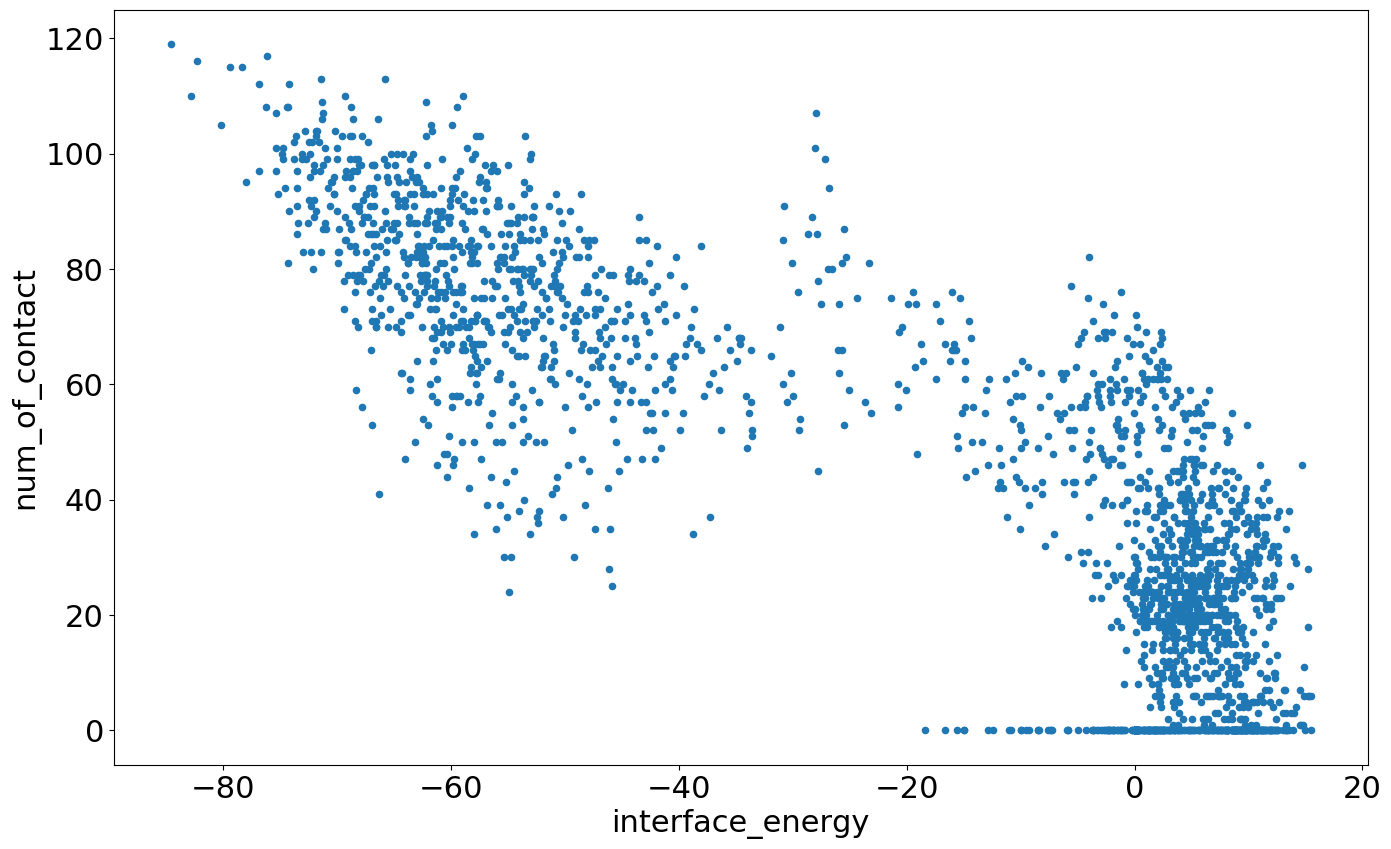

In [123]:
test_energy.plot.scatter("interface_energy", "num_of_contact")

In [ ]:

#Calculate native distances
CA_atoms=original_dna[original_dna.name=='CA']
P_atoms=original_dna[original_dna.name=='P']
d=sdist.cdist(CA_atoms[['x','y','z']],P_atoms[['x','y','z']])/10 #Distance in nanometers
d_sq=pd.DataFrame(d,index=CA_atoms.index,columns=P_atoms.index)
d=d_sq.copy()
d['Protein']=d.index
d=d.melt(id_vars=['Protein'])
d=d.rename(columns={'variable': 'DNA', 'value': 'distance'})

r_cutoff = 1.8
selection=d[d['distance']<r_cutoff].copy()
selection["new_DNA"] = selection["DNA"].apply(lambda x:index_convertion_dic[x])
selection["new_Protein"] = selection["Protein"].apply(lambda x:index_convertion_dic[x])

In [ ]:

# def compute_dis(pos1, pos2):
#     dis = pos1 - pos2
#     r = (dis[0]**2 + dis[1]**2 + dis[2]**2)**0.5
#     return r

# def count_contact(interaction_table, frame, r_cutoff=1.8):
#     count = 0
#     for i, line in interaction_table.iterrows():
#         protein_pos_index = line["new_Protein"]
#         protein_pos = frame[protein_pos_index]
#         dna_pos_index = line["new_DNA"]
#         dna_pos = frame[dna_pos_index]
#         r = compute_dis(protein_pos, dna_pos)
#         if r < r_cutoff:
#             count += 1
#     # print(count)
#     return count

In [81]:
save = count_list

In [ ]:
for frame in range(len(dcd_traj)):
    d2=sdist.cdist(dcd_traj.xyz[frame][protein_contacts],dcd_traj.xyz[frame][list(P_atoms.index)])
    out+=[np.exp(-(d2.min(axis=1)-d1.min(axis=1))**2/(2*.5**2))]

In [69]:
for i, line in selection.iterrows():
    count = 0
    protein_pos_index = line["new_Protein"]
    protein_pos = frame[protein_pos_index]
    dna_pos_index = line["new_DNA"]
    dna_pos = frame[dna_pos_index]
    r = compute_dis(protein_pos, dna_pos)
    if r < r_cutoff:
        count += 1
print(count)

0


31.85687365434489

In [64]:
protein_pos

array([12.4894,  0.2627,  4.882 ], dtype=float32)

In [65]:
dna_pos

array([-1.7645, -0.2216, 33.368 ], dtype=float32)

In [46]:
frame.shape

(3064, 3)

In [17]:

#Calculate native distances
CA_atoms=original_dna.query("name == 'CA'")
P_atoms=original_dna.query("name == 'P'")
d=sdist.cdist(CA_atoms[['x','y','z']],P_atoms[['x','y','z']])/10 #Distance in nanometers
d_sq=pd.DataFrame(d,index=CA_atoms.index,columns=P_atoms.index)
d=d_sq.copy()
d['Protein']=d.index
d=d.melt(id_vars=['Protein'])
d=d.rename(columns={'variable': 'DNA', 'value': 'distance'})

In [20]:
d_sq

,3,6,9,12,15,18,21,24,27,30,...,53,56,59,62,65,68,71,74,77,80
82,2.785808,2.800773,3.158283,3.530891,3.578420,3.388716,3.064037,2.575495,2.107018,1.895301,...,3.463425,3.061851,2.471553,1.943341,1.513524,1.786386,2.357141,2.976135,3.553084,3.939299
88,2.905843,2.832806,3.136352,3.489571,3.545084,3.377780,3.081928,2.600237,2.090450,1.777080,...,3.276026,2.842440,2.248920,1.780498,1.481193,1.873420,2.492226,3.105221,3.666390,4.024523
94,3.040721,2.955834,3.270837,3.658324,3.763914,3.646983,3.390591,2.934582,2.425081,2.070250,...,3.466525,2.986435,2.372913,1.933623,1.719328,2.168961,2.808944,3.406475,3.945789,4.264928
100,3.296388,3.144416,3.401867,3.754920,3.850908,3.737823,3.493920,3.035134,2.492284,2.054014,...,3.376487,2.885387,2.298251,1.954858,1.865749,2.370464,3.022973,3.615652,4.146136,4.452715
106,3.430172,3.238404,3.476516,3.841152,3.978362,3.916797,3.720211,3.297453,2.765230,2.301399,...,3.460569,2.928838,2.341936,2.055926,2.068531,2.621884,3.290629,3.861417,4.363535,4.626860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,1.511693,1.526670,1.897182,2.275179,2.352045,2.246446,2.048129,1.812848,1.702627,1.890077,...,2.923860,2.572860,2.024104,1.366525,0.703117,0.604800,1.146093,1.666893,2.179224,2.518710
1843,1.840692,1.900815,2.254264,2.587470,2.596412,2.401031,2.107004,1.762716,1.579390,1.758093,...,3.016872,2.704201,2.173952,1.542942,0.853269,0.698697,1.188832,1.779954,2.350435,2.760523
1849,1.805781,1.866756,2.167900,2.432509,2.376689,2.130197,1.809223,1.499160,1.437029,1.753790,...,2.915665,2.672603,2.209932,1.617153,0.941614,0.497517,0.825378,1.428330,2.021740,2.479044
1855,1.595872,1.795117,2.189892,2.521382,2.525606,2.335957,2.061680,1.820898,1.811260,2.131094,...,3.246942,2.986551,2.502756,1.879207,1.201663,0.779409,0.960558,1.467192,2.019087,2.449114


In [18]:
d

,Protein,DNA,distance
0,82,3,2.785808
1,88,3,2.905843
2,94,3,3.040721
3,100,3,3.296388
4,106,3,3.430172
...,...,...,...
7873,1837,80,2.518710
7874,1843,80,2.760523
7875,1849,80,2.479044
7876,1855,80,2.449114


In [16]:
d

,Protein,DNA,distance
0,82,3,2.785808
1,88,3,2.905843
2,94,3,3.040721
3,100,3,3.296388
4,106,3,3.430172
...,...,...,...
7873,1837,80,2.518710
7874,1843,80,2.760523
7875,1849,80,2.479044
7876,1855,80,2.449114
